# Import packages and data 

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import scipy.stats
import anndata
import matplotlib.pyplot as plt
import matplotlib as mpl
import rpy2

In [2]:
sc.settings.verbosity = 1  # verbosity: errors (0), warnings (1), info (2), hints (3)
# Set up the plot config for viewing the annotation clearly.
sc.settings.set_figure_params(dpi=120, dpi_save=1000)
sc.logging.print_versions()

scanpy==1.4.4 anndata==0.7.1 umap==0.3.10 numpy==1.17.1 scipy==1.4.1 pandas==0.23.4 scikit-learn==0.22.2.post1 statsmodels==0.11.1 python-igraph==0.8.0 louvain==0.6.1


# Load FBM 

In [3]:
adata = sc.read('/Users/b8058304/Documents/PhD_work/Coding/downs_bm/data/downs_raw_dr_20200311.h5ad')

In [4]:
adata.raw = adata

In [5]:
cell_numbers = adata.obs.groupby(["cell.labels"]).apply(len)
cell_numbers

cell.labels
CAR                          4
CD8 T cell                  55
CD14 monocyte              252
CD56 bright NK              36
CMP                         37
DC1                         16
DC2                         94
DC3                         98
HSC                         45
ILC precursor               13
MEMP                        42
MK                          25
MSC                         18
Treg                         8
chondrocyte                  4
early B                     23
early MK                     7
early erythroid            766
endothelium                 37
eo/baso/mast precursor      40
eosinophil                  41
late erythroid            3341
macrophage                  64
mast cell                   27
mature B                    20
mature NK                   69
mid erythroid             2082
monocyte precursor         172
myelocyte                  218
neut-myeloid prog.          27
neutrophil                 245
neutrophil precursor       

In [6]:
celltypes = ['HSC', 'MEMP', 'early erythroid']

In [7]:
adata = adata[adata.obs['cell.labels'].isin(celltypes)].copy()

In [8]:
cell_numbers = adata.obs.groupby(["cell.labels"]).apply(len)
cell_numbers

cell.labels
HSC                 45
MEMP                42
early erythroid    766
dtype: int64

In [9]:
adata.shape

(853, 33694)

# Pre-process the dataset

In [10]:
# normalise count data 
sc.pp.normalize_total(adata)

In [11]:
# log the count data 
sc.pp.log1p(adata)

In [12]:
# find variable genes
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5) 

In [13]:
# scale the data 
sc.pp.scale(adata, max_value=10)

In [14]:
# scale the negative values in adata.X (which have been normalised, logged and scaled) to zero 
adata.X = np.where(adata.X < 0, 0, adata.X)

In [15]:
# run pca
sc.tl.pca(adata, n_comps=50)

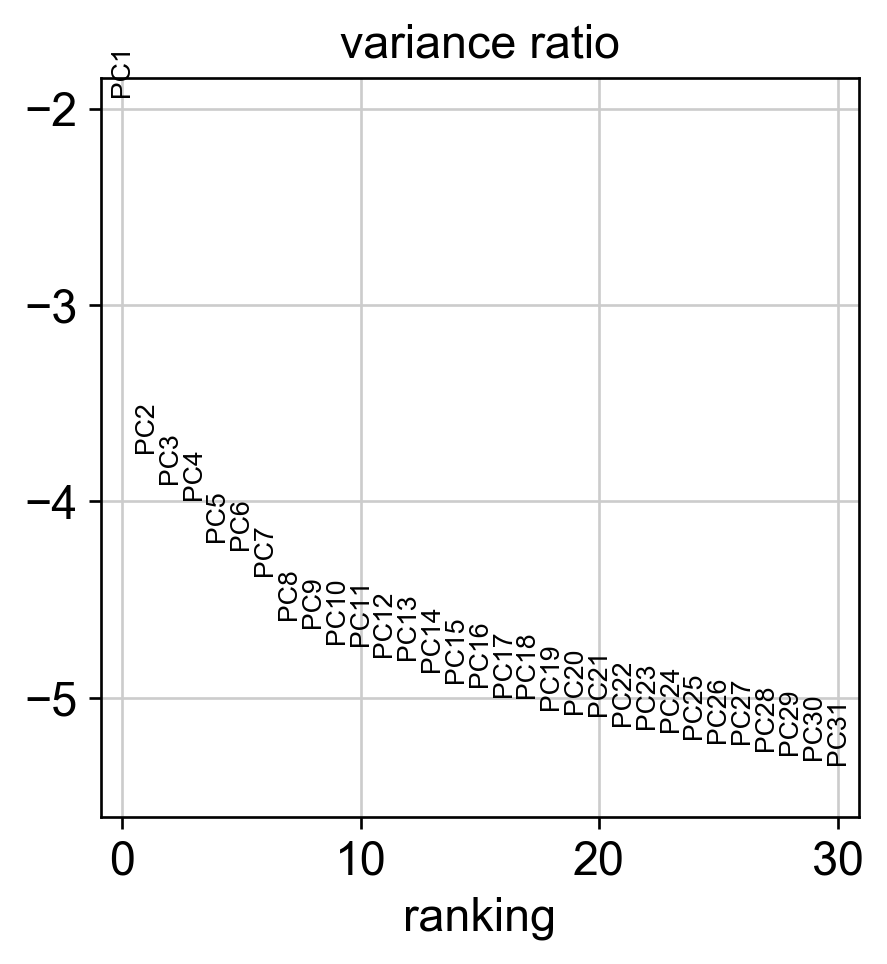

In [16]:
# have a look at pc's in order to choose number of pcs that will be used downstream 
sc.pl.pca_variance_ratio(adata, log=True)

In [17]:
# run snn neighbourhood graph
sc.pp.neighbors(adata, n_neighbors=40, n_pcs=10) 

In [18]:
# run umap
sc.tl.umap(adata) 

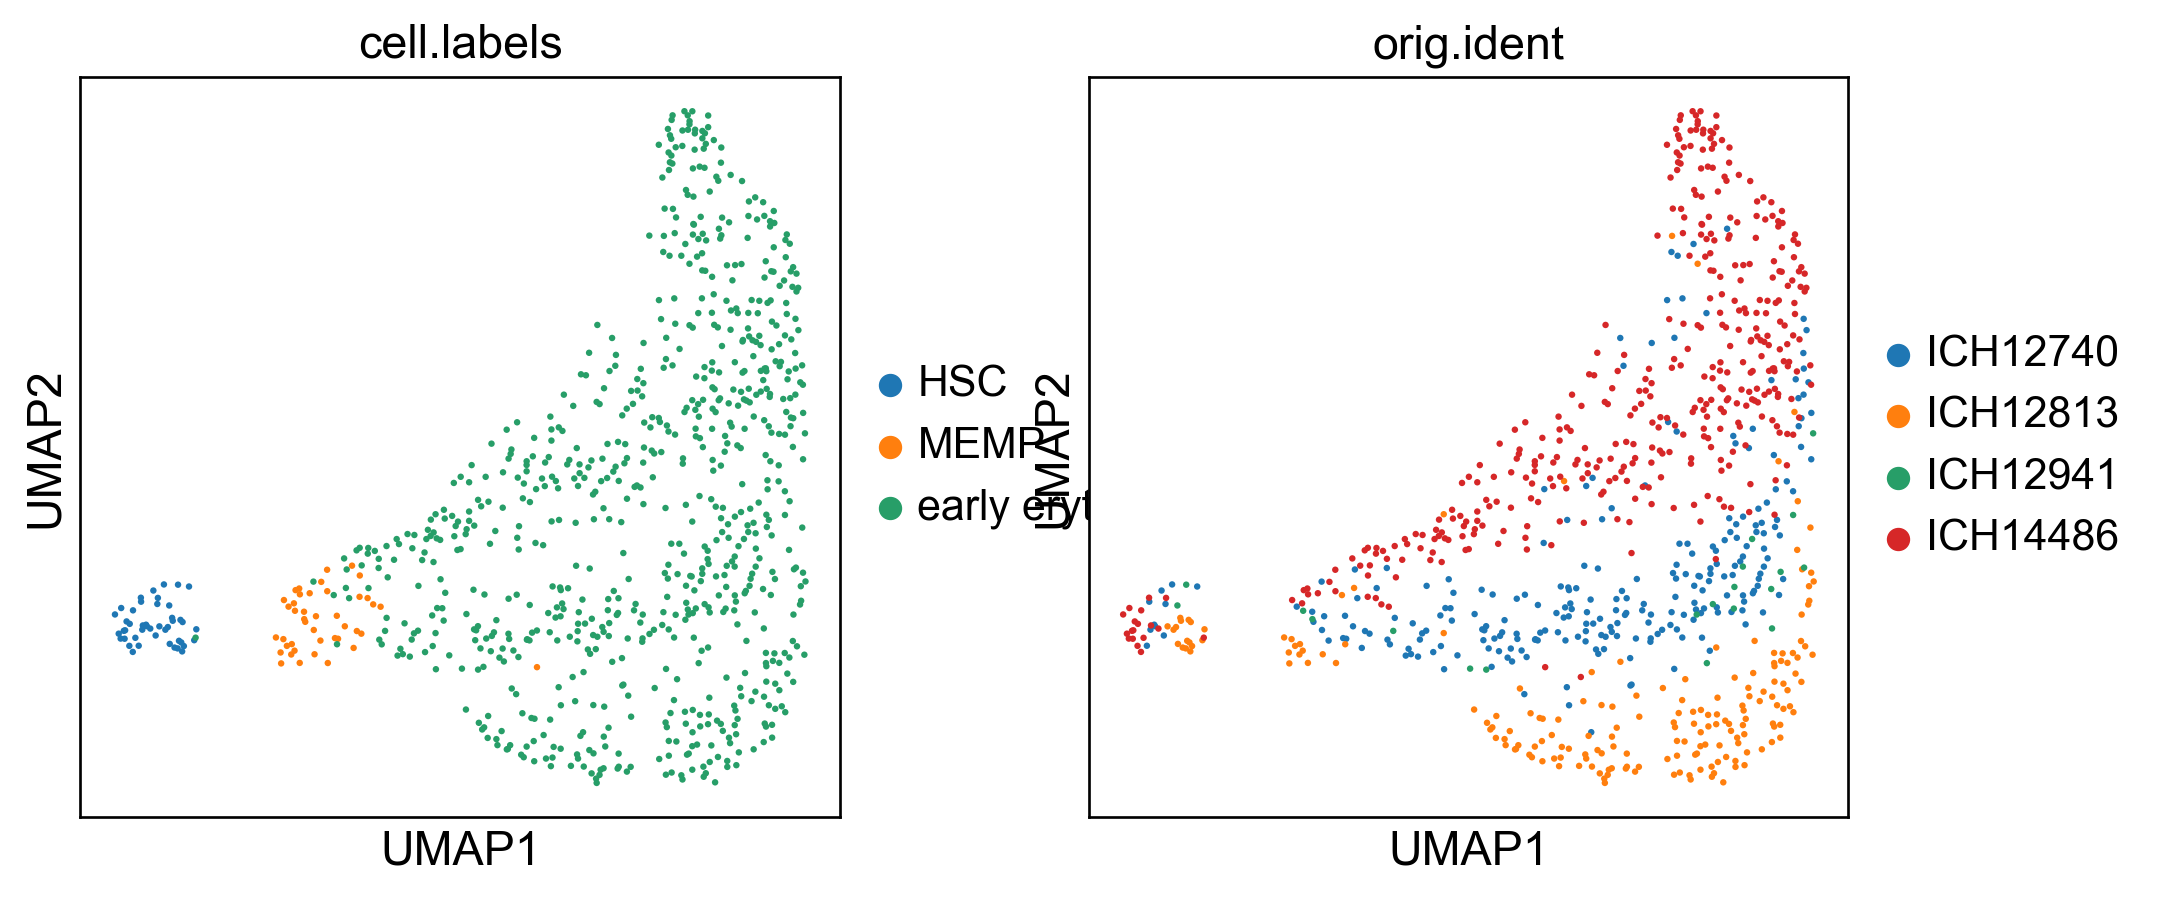

In [19]:
sc.pl.umap(adata, color=['cell.labels', 'orig.ident'], size=15) 

# Run harmony batch correction

In [20]:
#harmony prep - save pca and batch (sample) metadata columns 
pca = adata.obsm['X_pca']
batch = adata.obs['orig.ident']

In [21]:
# load up harmony in rpy2
%load_ext rpy2.ipython

In [22]:
%%R -i pca -i batch -o hem

library(harmony)
library(magrittr)

hem = HarmonyMatrix(pca, batch, theta=3, verbose=TRUE, do_pca=FALSE)
hem = data.frame(hem)

R[write to console]: Loading required package: Rcpp

R[write to console]: Harmony 1/10

R[write to console]: 0%   10   20   30   40   50   60   70   80   90   100%

R[write to console]: [----|----|----|----|----|----|----|----|----|----|

R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[

In [23]:
# save old pca values or orig.pca and save batch corrected pca results in anndata object as x_pca
adata.obsm['X_orig_pca'] = adata.obsm['X_pca']
adata.obsm['X_pca'] = hem.values

# Add dimensional reduction post-harmony

In [24]:
# run snn neighbourhood graph
sc.pp.neighbors(adata, n_neighbors=40, n_pcs=10) 

In [25]:
# run umap
sc.tl.umap(adata) 

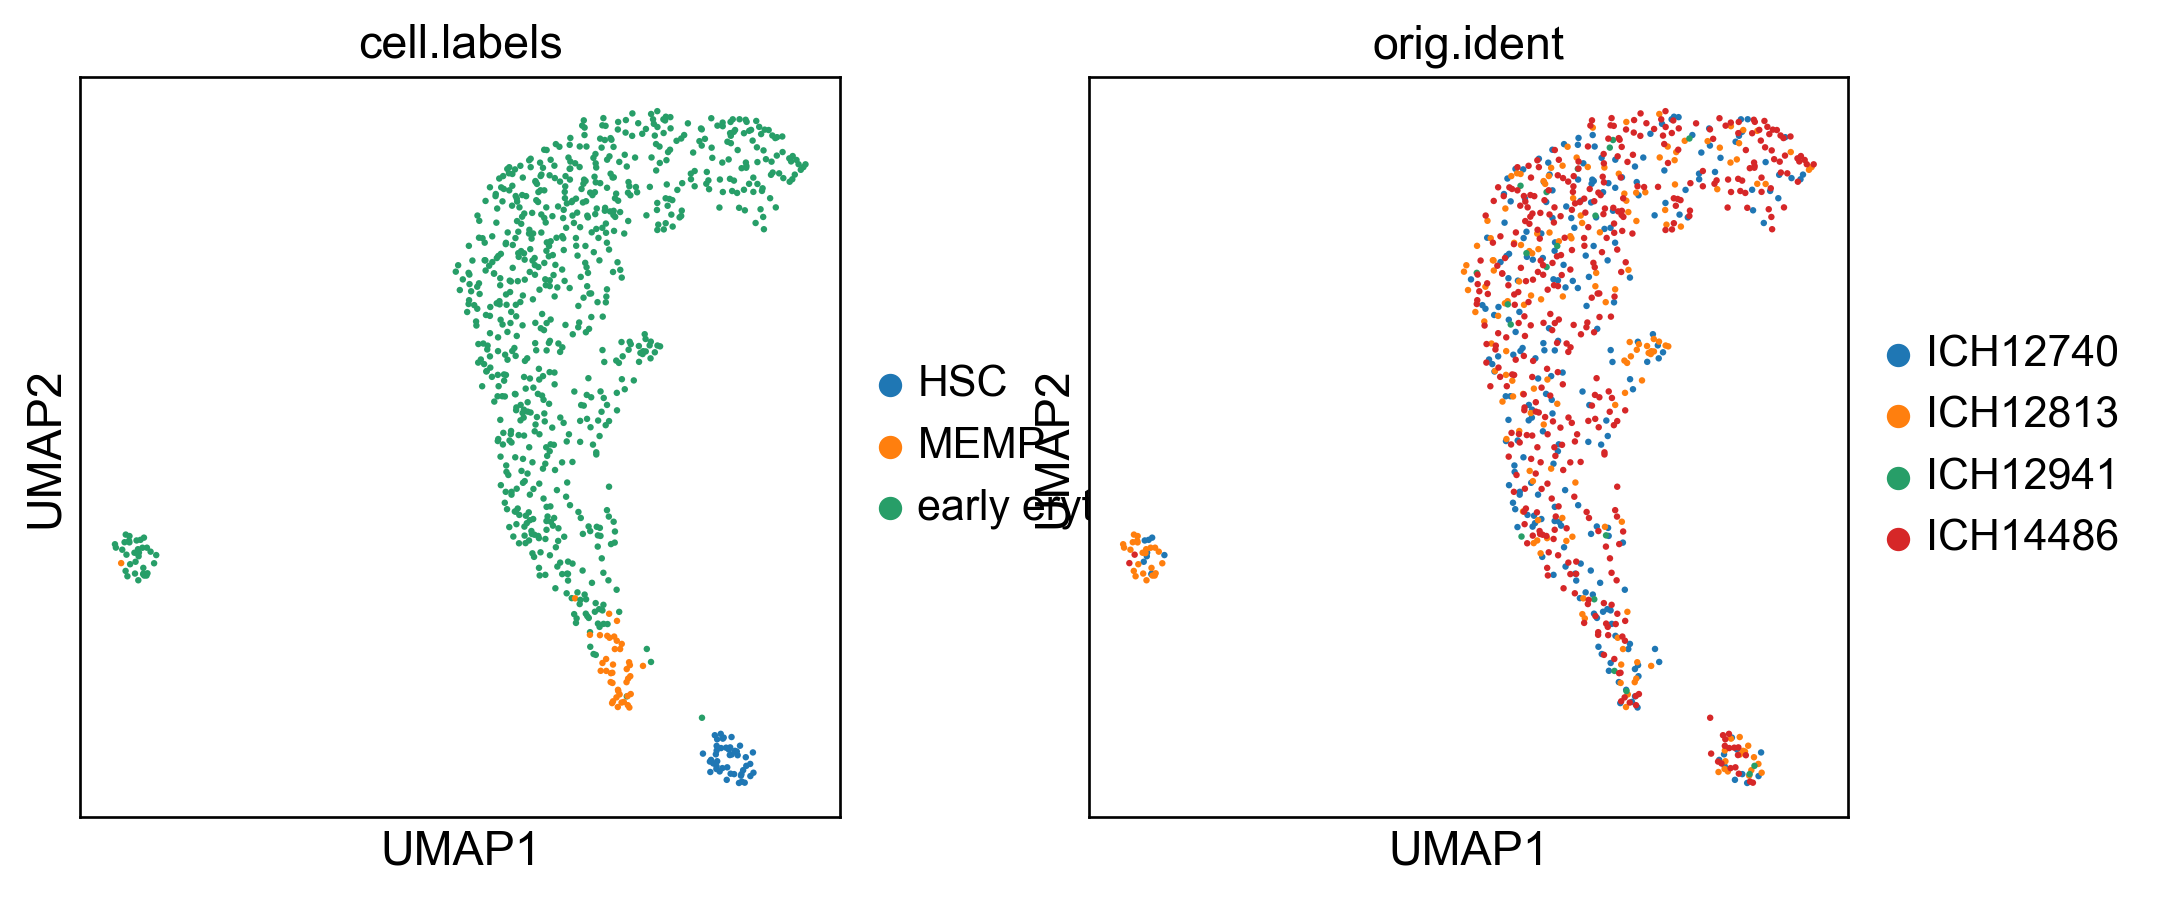

In [26]:
sc.pl.umap(adata, color=['cell.labels', 'orig.ident'], size=15) 

In [27]:
# run fdg 
# As an input, FDG requires PCA coordinates and a snn graph. must redo snn graph if re-running fdg on subsets 
sc.tl.draw_graph(adata, init_pos='X_pca', layout='fa')

# Change the colours for the gran and neut lineage

In [28]:
adata.obs["cell.labels"] = adata.obs["cell.labels"].astype('category')
adata.obs["cell.labels"].cat.categories

Index(['HSC', 'MEMP', 'early erythroid'], dtype='object')

In [29]:
adata.obs["cell.labels"] = adata.obs["cell.labels"].cat.reorder_categories(['HSC', 'MEMP',  
                'early erythroid'])

In [30]:
adata.obs["cell.labels"] = adata.obs["cell.labels"].astype('category')
adata.obs["cell.labels"].cat.categories

Index(['HSC', 'MEMP', 'early erythroid'], dtype='object')

In [31]:
adata.obs["cell.labels"].cat.categories[2]

'early erythroid'

In [32]:
new_colors = np.array(adata.uns["cell.labels_colors"])

new_colors[[0]] = '#d200d2' # HSC
new_colors[[1]] = '#00a500' # MEMP
new_colors[[2]] = '#cbcbff' # early erythroid
adata.uns["cell.labels_colors"] = new_colors

new_colors

array(['#d200d2', '#00a500', '#cbcbff'], dtype='<U7')

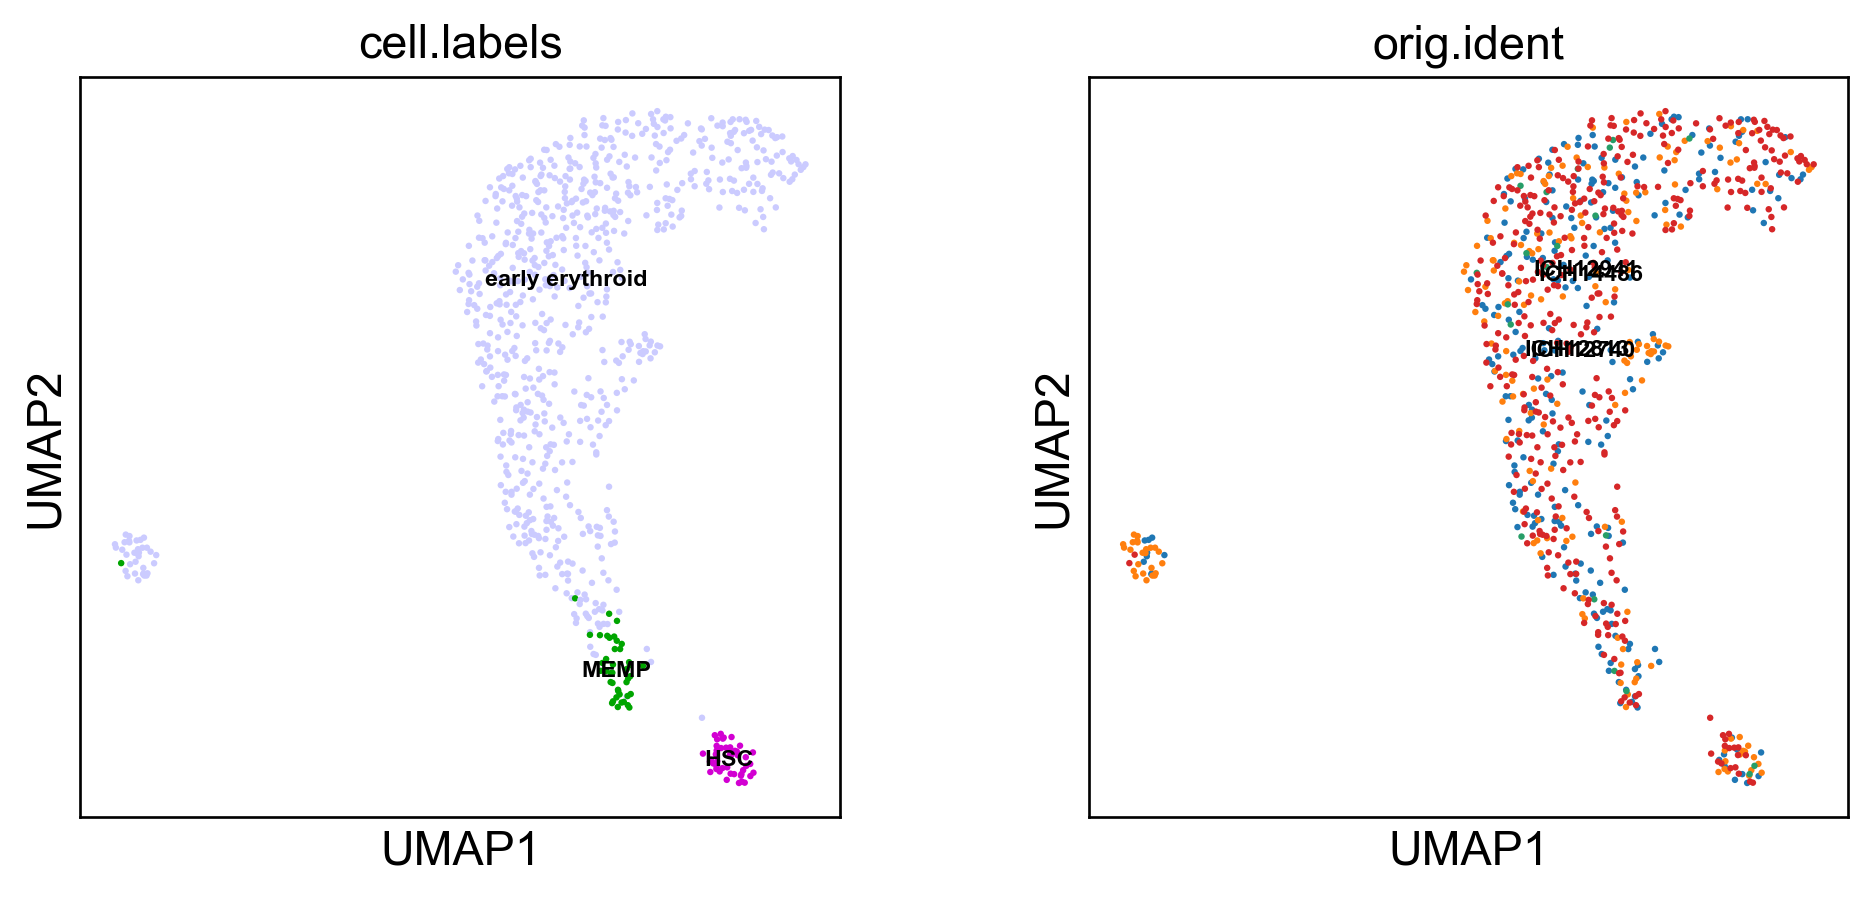

In [33]:
sc.pl.umap(adata, color=['cell.labels', 'orig.ident'], size=15, legend_loc="on data", legend_fontsize=7) 

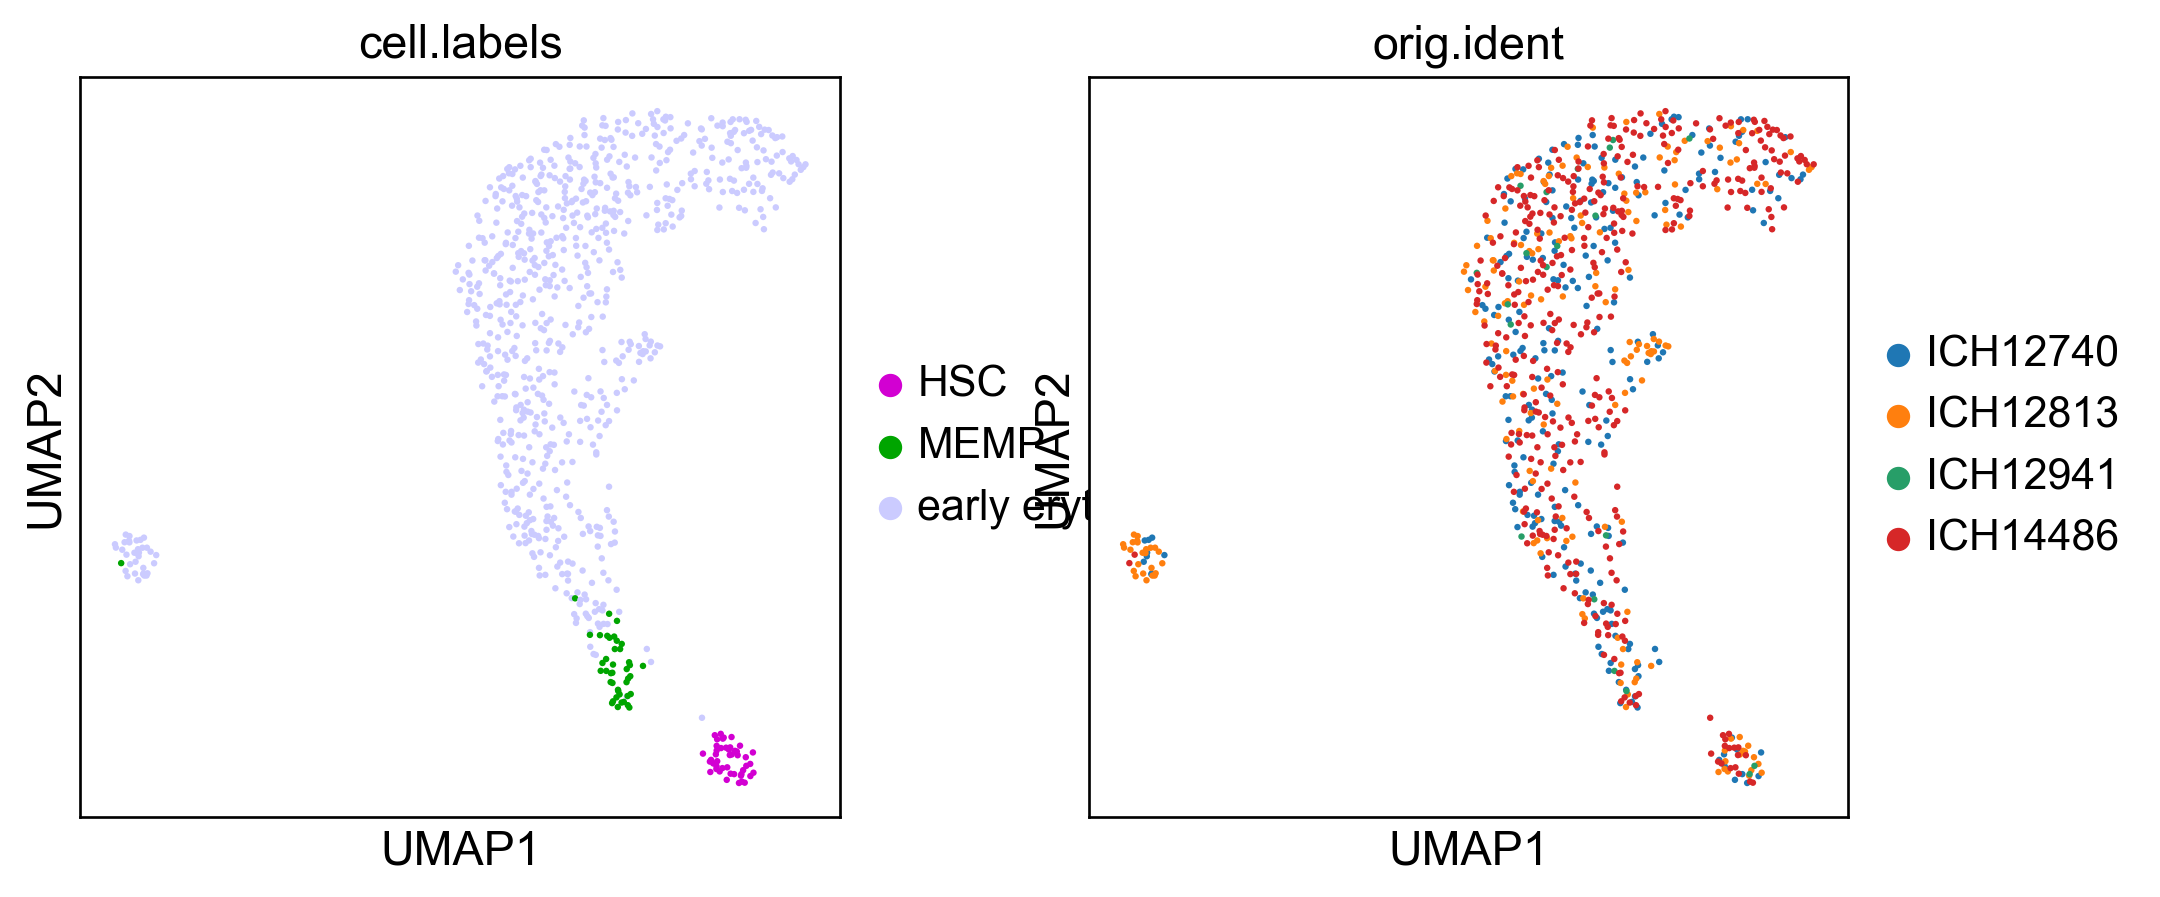

In [34]:
sc.pl.umap(adata, color=['cell.labels', 'orig.ident'], size=15) 

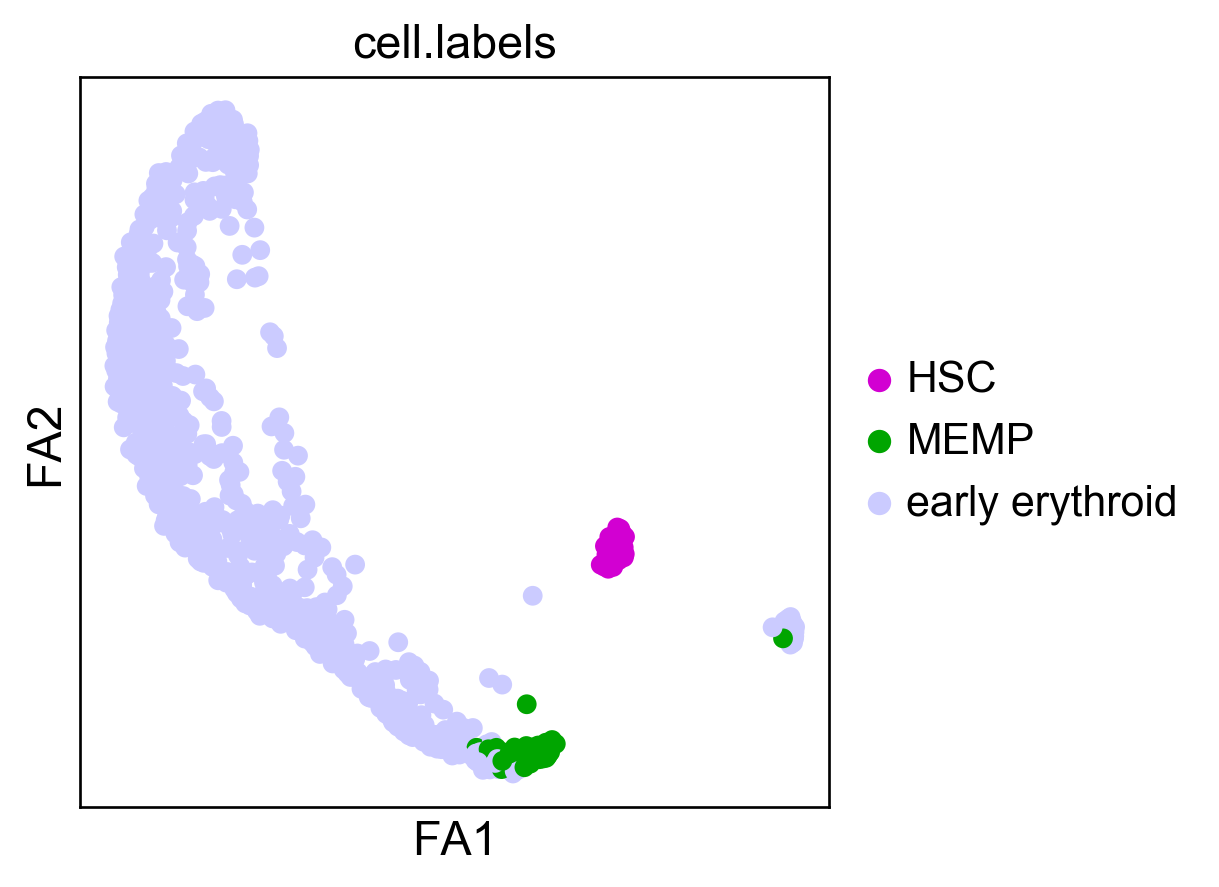

In [35]:
sc.pl.draw_graph(adata, color='cell.labels', layout='fa') 

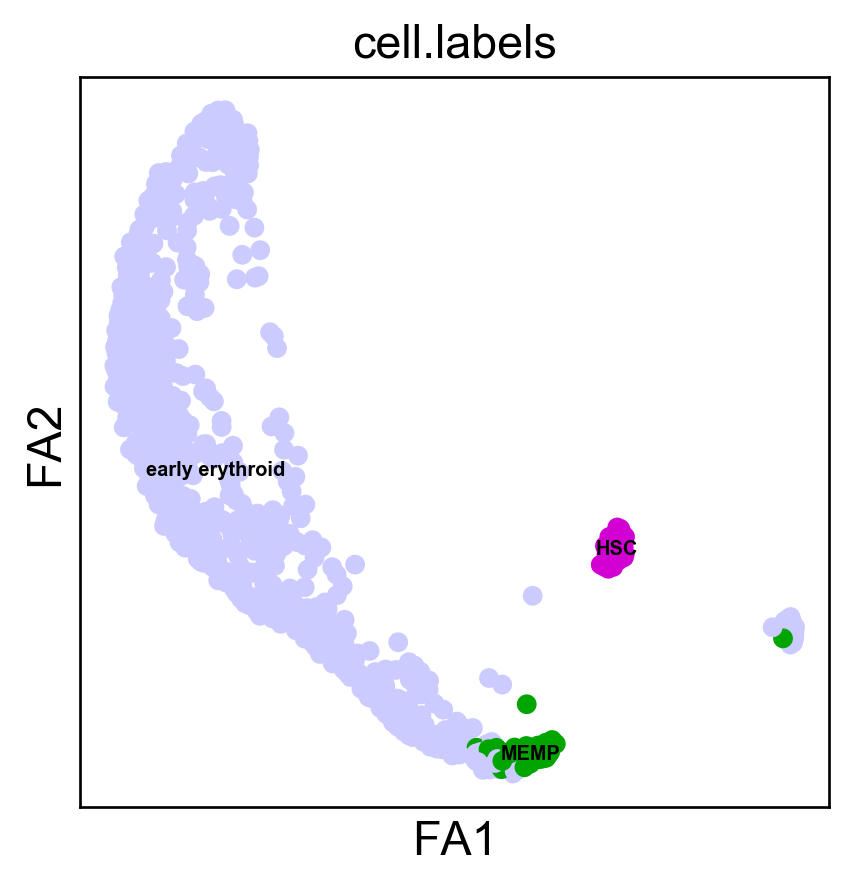

In [36]:
sc.pl.draw_graph(adata, color='cell.labels', legend_loc='on data', legend_fontsize=6) 

# Save plots

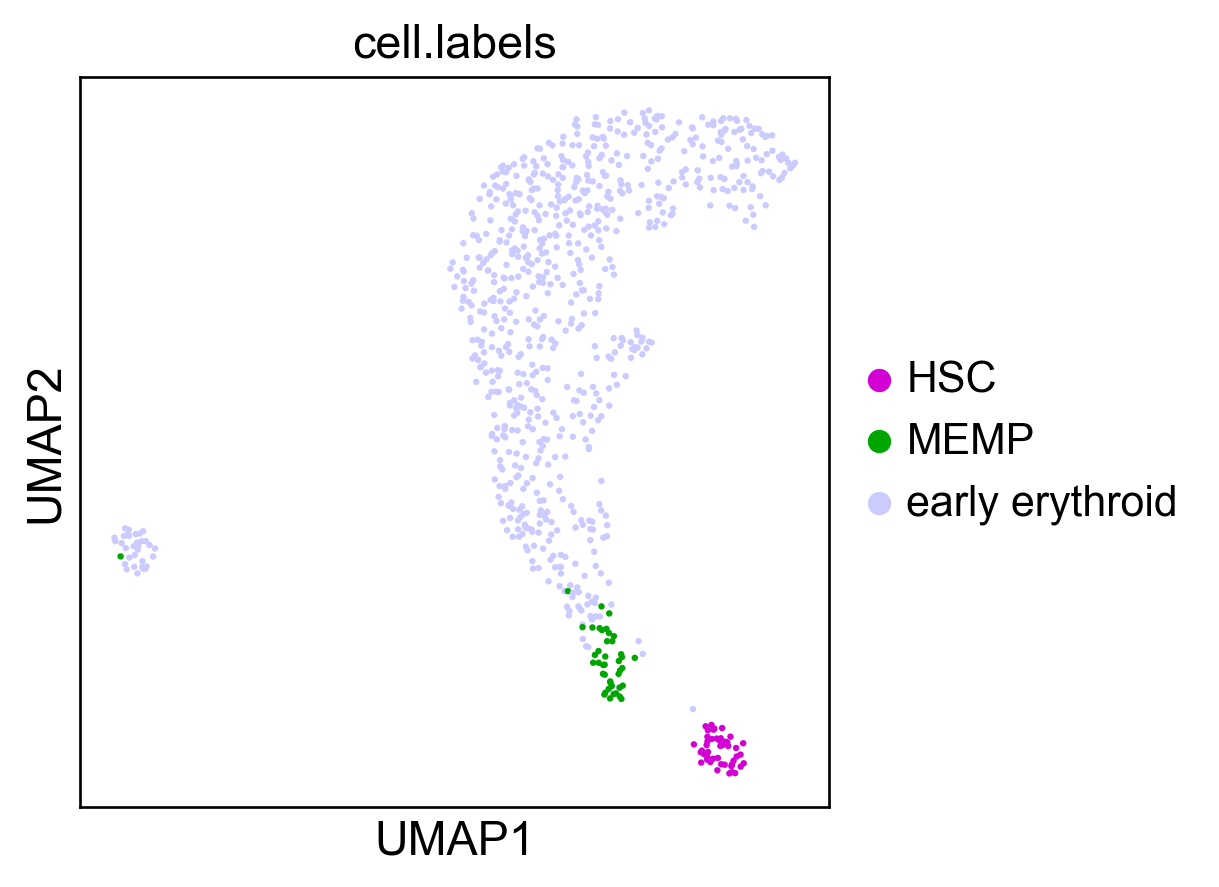

In [37]:
sc.settings.set_figure_params(dpi=120, dpi_save=1000)
sc.pl.umap(adata, color=['cell.labels'], size=15, save="fig5e_5f_downs_eryth_umap_20200625.pdf") 

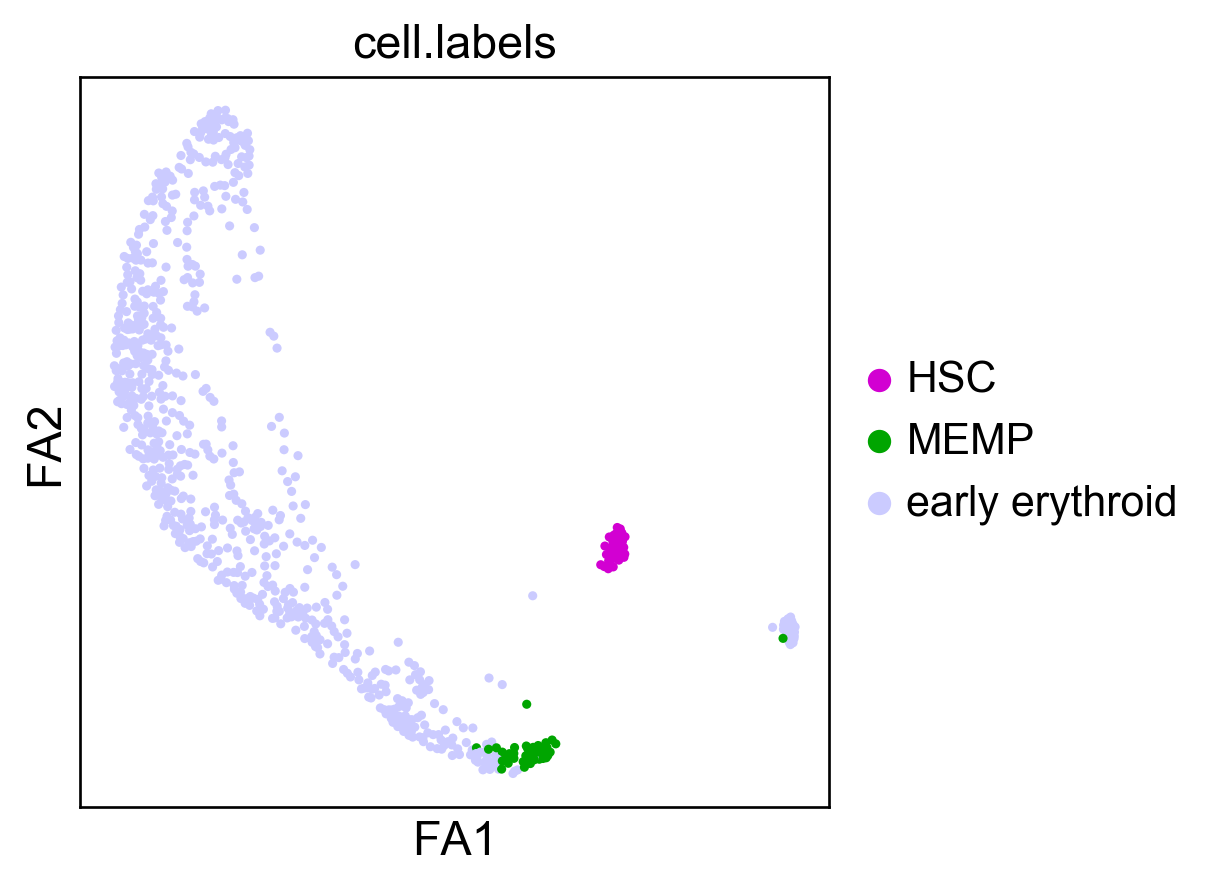

In [38]:
sc.pl.draw_graph(adata, color='cell.labels', layout='fa', show=True, save='_fig5e_5f_downs_eryth_fdg_size30_20200625.pdf', 
                 size=30)

# Save the data

In [39]:
from scipy.sparse import csr_matrix
adata.X = scipy.sparse.csr_matrix(adata.X)

In [40]:
adata.X

<853x33694 sparse matrix of type '<class 'numpy.float32'>'
	with 3157910 stored elements in Compressed Sparse Row format>

In [41]:
adata.raw.X

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [42]:
adata.write("/Users/b8058304/Documents/PhD_work/Coding/manuscript_figs/data/fig5e_5f_downs_eryth_dr_20200625.h5ad")